In [1]:
from importlib.metadata import version

pkgs = [
    "matplotlib",
    "numpy",
    "tiktoken",
    "torch",
    "tensorflow",
    "pandas"
]

for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.7.2
numpy version: 1.24.3
tiktoken version: 0.6.0
torch version: 2.1.2
tensorflow version: 2.13.0
pandas version: 2.0.3


### Dataset prep

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"
data_file_path

PosixPath('sms_spam_collection/SMSSpamCollection.tsv')

In [3]:
def download_and_unzip(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists, no need to download")
        return
    
    # download the file
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())
    
    # unzip the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)
    
    # add .tsv extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

In [4]:
download_and_unzip(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists, no need to download


In [5]:
import pandas as pd
df = pd.read_csv(data_file_path, sep='\t', header=None, names=["label", "text"])

In [6]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
df.shape

(5572, 2)

In [8]:
df['label'].value_counts()
# unbalanced dataset

label
ham     4825
spam     747
Name: count, dtype: int64

In [9]:
df[df.label == 'spam'].shape

(747, 2)

In [10]:
def create_balanced_dataset(df):
    num_spam = df[df.label == 'spam'].shape[0]
    ham_subset = df[df.label == 'ham'].sample(num_spam, random_state=123)
    balanced_df = pd.concat([ham_subset, df[df.label == 'spam']])
    return balanced_df

In [11]:
balanced_df = create_balanced_dataset(df)
balanced_df['label'].value_counts()

label
ham     747
spam    747
Name: count, dtype: int64

In [12]:
balanced_df.shape

(1494, 2)

In [13]:
balanced_df['label'] = balanced_df['label'].map({'ham': 0, 'spam': 1})

In [14]:
balanced_df[balanced_df.label == 1]

,label,text
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
5,1,FreeMsg Hey there darling it's been 3 week's n...
8,1,WINNER!! As a valued network customer you have...
9,1,Had your mobile 11 months or more? U R entitle...
11,1,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


In [15]:
balanced_df.sample(frac=1).reset_index()

,index,label,text
0,3568,1,Collect your VALENTINE'S weekend to PARIS inc ...
1,1537,0,How's it feel? Mr. Your not my real Valentine ...
2,4531,0,Don't forget though that I love you .... And I...
3,8,1,WINNER!! As a valued network customer you have...
4,3102,0,Pathaya enketa maraikara pa'
...,...,...,...
1489,3437,0,If india win or level series means this is rec...
1490,2525,1,FREE entry into our £250 weekly comp just send...
1491,2409,0,Dear where you will be when i reach there
1492,2521,0,Misplaced your number and was sending texts to...


In [16]:
balanced_df.columns

Index(['label', 'text'], dtype='object')

In [17]:
def random_split(df, train_frac, validation_frac):
    # shuffle dataframe
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)
    
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)
    train_df = df[:train_end]
    valid_df = df[train_end: validation_end]
    test_df = df[validation_end:]

    return train_df, valid_df, test_df

In [18]:
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.shape, validation_df.shape, test_df.shape

((1045, 2), (149, 2), (300, 2))

In [19]:
train_df.to_csv('train.csv', index=None)
validation_df.to_csv('validation.csv', index=None)
test_df.to_csv('test.csv', index=None)

### Creating data loaders

In [20]:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})

[50256]

In [21]:
tokenizer.encode("How are you doing")

[2437, 389, 345, 1804]

In [22]:
# tokenizer.encode??

In [23]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256) -> None:
        self.data = pd.read_csv(csv_file)

        # pre-tokenizer texts
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data['text']
        ]
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # truncate texts if they are longer than max length
            self.encoded_texts = [
                encoded_text[:self.max_length] for encoded_text in self.encoded_texts
            ]
        
        # Add padding
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]
    
    def __getitem__(self, index):
        encoded_text = self.encoded_texts[index]
        label = self.data.iloc[index]['label']
        return (
            torch.tensor(encoded_text, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )
    
    def __len__(self):
        return len(self.data)
        
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            if len(encoded_text) > max_length:
                max_length = len(encoded_text)
        return max_length

In [24]:
data = {'Name': ['Alice', 'Bob', 'Charlie', 'David'],
        'Age': [25, 30, 35, 40],
        'City': ['New York', 'Los Angeles', 'Chicago', 'Houston']}

df = pd.DataFrame(data)
df.iloc[0]['Name']

'Alice'

In [25]:
train_dataset = SpamDataset(
    csv_file='train.csv',
    max_length=None,
    tokenizer=tokenizer
)
print(train_dataset.max_length)

120


In [26]:
validation_dataset = SpamDataset(
    csv_file='validation.csv',
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file='test.csv',
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [27]:
validation_dataset.max_length, test_dataset.max_length

(120, 120)

In [28]:
# create dataloaders
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True
)

val_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False
)

In [29]:
# DataLoader??

In [30]:
for text, label in test_loader:
    print(text.shape, label.shape)
    break

torch.Size([8, 120]) torch.Size([8])


In [31]:
len(train_loader), len(val_loader), len(test_loader)

(130, 19, 38)

In [32]:
import os
import requests
import json
import numpy as np
import tensorflow as tf
from tqdm import tqdm

In [33]:
base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
filename = 'checkpoint'
model_dir = 'downloaded_models'
model_size = '124M'

file_url = os.path.join(base_url, model_size, filename)
file_path = os.path.join(model_dir, filename)
file_url, file_path

('https://openaipublic.blob.core.windows.net/gpt-2/models/124M/checkpoint',
 'downloaded_models/checkpoint')

In [34]:
os.makedirs(model_dir, exist_ok=True)

In [35]:
response = requests.get(file_url, stream=True)
response.headers

{'Content-Length': '77', 'Content-Type': 'application/octet-stream', 'Content-MD5': 'ygNo/NPEwamaykJRHQwfEg==', 'Last-Modified': 'Wed, 02 Dec 2020 17:33:04 GMT', 'ETag': '0x8D896E85318642F', 'Server': 'Windows-Azure-Blob/1.0 Microsoft-HTTPAPI/2.0', 'x-ms-request-id': 'b9b36587-e01e-0009-68bb-aa4c5c000000', 'x-ms-version': '2009-09-19', 'x-ms-meta-Mtime': '2019-09-17T04:52:11.325000000Z', 'x-ms-lease-status': 'unlocked', 'x-ms-blob-type': 'BlockBlob', 'Date': 'Mon, 20 May 2024 13:41:24 GMT'}

In [36]:
file_size = int(response.headers.get("content-length", 0))
block_size = 1024
progress_bar_description = url.split("/")[-1]
with tqdm(total=file_size, unit='iB', unit_scale=True, desc=progress_bar_description) as progress_bar:
    with open(file_path, "wb") as file:
        for chunk in response.iter_content(block_size):
            progress_bar.update(len(chunk))
            file.write(chunk)

sms+spam+collection.zip: 100%|██████████| 77.0/77.0 [00:00<00:00, 93.8kiB/s]


In [37]:
tk_ckpt_path = tf.train.latest_checkpoint(model_dir)
tk_ckpt_path

ERROR:tensorflow:Couldn't match files for checkpoint downloaded_models/model.ckpt


In [38]:
def download_file(file_path, destination):
    response = requests.get(file_path, stream=True)
    file_size = int(response.headers.get("content-length", 0))
    if os.path.exists(destination):
        file_size_local = os.path.getsize(destination)
        if file_size == file_size_local:
            print(f"File exists: {destination}")
            return

    block_size = 1024
    progress_bar_description = file_path.split("/")[-1]
    with tqdm(total=file_size, unit='iB', unit_scale=True, desc=progress_bar_description) as progress_bar:
        with open(destination, "wb") as file:
            for chunk in response.iter_content(block_size):
                progress_bar.update(len(chunk))
                file.write(chunk)

In [39]:
def download_and_load_gpt2(model_size, models_dir):
    # model sizes available in https://github.com/openai/gpt-2/blob/master/DEVELOPERS.md
    allowed_sizes = ('124M', '355M', '774M', '1558M')
    if model_size not in allowed_sizes:
        raise ValueError(f"Model size {model_size} not in {allowed_sizes}")
    
    # define paths
    model_dir = os.path.join(models_dir, model_size)
    base_url = "https://openaipublic.blob.core.windows.net/gpt-2/models"
    filenames = [
        'checkpoint','encoder.json','hparams.json',
        'model.ckpt.data-00000-of-00001', 'model.ckpt.index',
        'model.ckpt.meta', 'vocab.bpe'
    ]

    # download files
    os.makedirs(model_dir, exist_ok=True)
    for filename in filenames:
        file_url = os.path.join(base_url, model_size, filename)
        file_path = os.path.join(model_dir, filename)
        print(file_url, file_path)
        download_file(file_url, file_path)
    
    # Add tf loading part

In [40]:
download_and_load_gpt2(model_size='124M', models_dir='gpt2')

https://openaipublic.blob.core.windows.net/gpt-2/models/124M/checkpoint gpt2/124M/checkpoint
File exists: gpt2/124M/checkpoint
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json gpt2/124M/encoder.json
File exists: gpt2/124M/encoder.json
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/hparams.json gpt2/124M/hparams.json
File exists: gpt2/124M/hparams.json
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.data-00000-of-00001 gpt2/124M/model.ckpt.data-00000-of-00001
File exists: gpt2/124M/model.ckpt.data-00000-of-00001
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.index gpt2/124M/model.ckpt.index
File exists: gpt2/124M/model.ckpt.index
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.meta gpt2/124M/model.ckpt.meta
File exists: gpt2/124M/model.ckpt.meta
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe gpt2/124M/vocab.bpe
File exists: gpt2/124M/vocab.bpe


In [41]:
model_dir = os.path.join('gpt2', '124M')

In [42]:
tf_ckpt_path = tf.train.latest_checkpoint(model_dir)
tf_ckpt_path

'gpt2/124M/model.ckpt'

In [43]:
settings = json.load(open(os.path.join(model_dir, 'hparams.json')))
settings

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

In [44]:
variables = tf.train.list_variables(tf_ckpt_path)

In [45]:
name, _ = variables[1]

In [46]:
name

'model/h0/attn/c_attn/w'

In [47]:
tf.train.load_variable(tf_ckpt_path, name).shape

(1, 768, 2304)

In [48]:
def load_gpt2_params_from_tf_ckpt(ckpt_path, settings):
    # Initialize parameters dictionary with empty blocks for each layer
    params = {"blocks": [{} for _ in range(settings["n_layer"])]}

    # Iterate over each variable in the checkpoint
    for name, _ in tf.train.list_variables(ckpt_path):
        # Load the variable and remove singleton dimensions
        variable_array = np.squeeze(tf.train.load_variable(ckpt_path, name))

        # Process the variable name to extract relevant parts
        variable_name_parts = name.split("/")[1:]  # Skip the 'model/' prefix

        # Identify the target dictionary for the variable
        target_dict = params
        if variable_name_parts[0].startswith("h"):
            layer_number = int(variable_name_parts[0][1:])
            target_dict = params["blocks"][layer_number]

        # Recursively access or create nested dictionaries
        for key in variable_name_parts[1:-1]:
            target_dict = target_dict.setdefault(key, {})

        # Assign the variable array to the last key
        last_key = variable_name_parts[-1]
        target_dict[last_key] = variable_array

    return params

In [49]:
a = load_gpt2_params_from_tf_ckpt(tf_ckpt_path, settings)
a.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

In [50]:
a['wpe'].shape

(1024, 768)

In [51]:
a['blocks'][0].keys()

dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])

In [52]:
# tf.train.latest_checkpoint??

In [53]:
from utils.gpt_download import download_and_load_gpt2

In [54]:
settings, params = download_and_load_gpt2(model_size='124M', models_dir='gpt2')

https://openaipublic.blob.core.windows.net/gpt-2/models/124M/checkpoint gpt2/124M/checkpoint
File exists: gpt2/124M/checkpoint
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json gpt2/124M/encoder.json
File exists: gpt2/124M/encoder.json
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/hparams.json gpt2/124M/hparams.json
File exists: gpt2/124M/hparams.json
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.data-00000-of-00001 gpt2/124M/model.ckpt.data-00000-of-00001
File exists: gpt2/124M/model.ckpt.data-00000-of-00001
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.index gpt2/124M/model.ckpt.index
File exists: gpt2/124M/model.ckpt.index
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.meta gpt2/124M/model.ckpt.meta
File exists: gpt2/124M/model.ckpt.meta
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe gpt2/124M/vocab.bpe
File exists: gpt2/124M/vocab.bpe


In [55]:
x = torch.randn(8, 128, 128)
x.shape

torch.Size([8, 128, 128])

In [56]:
x.mean(dim=-1, keepdim=True).shape

torch.Size([8, 128, 1])

In [57]:
# x.var??

In [58]:
import torch
import torch.nn as nn

In [59]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
    
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


In [60]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [61]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg['emb_dim'], 4 * cfg['emb_dim']),
            GELU(),
            nn.Linear(4 * cfg['emb_dim'], cfg['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

In [62]:
tensor1 = torch.randn(3); tensor1.shape
tensor2 = torch.randn(3)
torch.matmul(tensor1, tensor2).size()

torch.Size([])

In [63]:
tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(4)
torch.matmul(tensor1, tensor2).size()

torch.Size([10, 3])

In [64]:
tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(10, 4, 5)
torch.matmul(tensor1, tensor2).size()

torch.Size([10, 3, 5])

In [65]:
tensor1 = torch.randn(10, 3, 4)
tensor2 = torch.randn(4)
torch.matmul(tensor1, tensor2).size()

torch.Size([10, 3])

In [66]:
tensor1 = torch.randn(10, 4, 3, 4)
tensor2 = torch.randn(10, 4, 4, 5)
(tensor1 @ tensor2).size()

torch.Size([10, 4, 3, 5])

In [67]:
mask = torch.triu(torch.ones(10, 10), diagonal=1).bool()[:5, :5]; mask

tensor([[False,  True,  True,  True,  True],
        [False, False,  True,  True,  True],
        [False, False, False,  True,  True],
        [False, False, False, False,  True],
        [False, False, False, False, False]])

In [68]:
attn_scores = torch.randn(1, 1, 5, 5); attn_scores

tensor([[[[-0.8746, -0.4962,  1.1485, -0.7213, -0.7052],
          [-0.3957, -1.2422,  0.7371, -0.6160,  1.7922],
          [-2.2315, -0.8595,  1.0116, -1.0823,  0.5964],
          [-0.1715,  0.7495,  0.7305, -0.2526, -0.5997],
          [ 0.5846, -0.7078, -1.4661,  0.9695,  0.4295]]]])

In [69]:
attn_scores.masked_fill_(mask, -torch.inf)

tensor([[[[-0.8746,    -inf,    -inf,    -inf,    -inf],
          [-0.3957, -1.2422,    -inf,    -inf,    -inf],
          [-2.2315, -0.8595,  1.0116,    -inf,    -inf],
          [-0.1715,  0.7495,  0.7305, -0.2526,    -inf],
          [ 0.5846, -0.7078, -1.4661,  0.9695,  0.4295]]]])

In [70]:
mask_l = torch.tril(torch.ones(10, 10))[:5, :5]
mask_l

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])

In [71]:
attn_scores_l = torch.randn(1, 1, 5, 5)
attn_scores_l.masked_fill_(mask_l==0, -torch.inf)

tensor([[[[ 1.2596,    -inf,    -inf,    -inf,    -inf],
          [-0.5895, -1.4847,    -inf,    -inf,    -inf],
          [-1.2648,  0.4248,  0.0476,    -inf,    -inf],
          [-0.4809,  0.1451, -3.1990,  0.3704,    -inf],
          [ 0.7145,  0.7502, -0.0951,  0.1211,  0.1435]]]])

In [72]:
torch.softmax??

Docstring:
softmax(input, dim, *, dtype=None) -> Tensor

Alias for :func:`torch.nn.functional.softmax`.
Type:      builtin_function_or_method

In [73]:
a = torch.softmax(attn_scores_l, dim=-1); a
dropout = nn.Dropout(0.3)
print(a, dropout(a))

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.7100, 0.2900, 0.0000, 0.0000, 0.0000],
          [0.0987, 0.5347, 0.3666, 0.0000, 0.0000],
          [0.1894, 0.3543, 0.0125, 0.4438, 0.0000],
          [0.2779, 0.2880, 0.1237, 0.1535, 0.1570]]]]) tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [1.0142, 0.4143, 0.0000, 0.0000, 0.0000],
          [0.1410, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.5061, 0.0179, 0.6340, 0.0000],
          [0.3970, 0.0000, 0.1767, 0.2193, 0.2243]]]])


In [74]:
0.6316 * (1.0 / 0.7)

0.9022857142857144

In [75]:
a.shape[-1]

5

In [76]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # transpose (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        
        # dot product for each head
        attn_scores = torch.matmul(queries, keys.transpose(2, 3)) # (b, num_heads, num_tokens, num_tokens) # double check this
        mask = self.mask[:num_tokens, :num_tokens].bool()
        attn_scores.masked_fill_(mask, -torch.inf)

        scaled_attn_scores = torch.softmax(attn_scores / keys.shape[-1] ** 0.5, dim=-1)
        scaled_attn_scores = self.dropout(scaled_attn_scores)

        # (b, num_heads, num_tokens, num_tokens) * 
        # (b, num_heads, num_tokens, head_dim) -> (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)
        context_vec = (scaled_attn_scores @ values).transpose(1, 2)
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)
        return context_vec

In [77]:
class SublayerConnection(nn.Module):
    '''
    Apply LN and residual connection.
    '''
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))

In [78]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg['emb_dim'],
            d_out=cfg['emb_dim'],
            context_length=cfg['context_length'],
            num_heads=cfg['n_heads'],
            dropout=cfg['drop_rate'],
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        # self.norm1 = LayerNorm(cfg['emb_dim'])
        # self.norm2 = LayerNorm(cfg['emb_dim'])
        # self.drop_resid = nn.Dropout(cfg['drop_rate'])
        self.sublayer1 = SublayerConnection(cfg['emb_dim'], cfg['drop_rate'])
        self.sublayer2 = SublayerConnection(cfg['emb_dim'], cfg['drop_rate'])
    
    def forward(self, x):
        # might have some interesting consequences when we load weights
        # attention block
        x = self.sublayer1(x, self.att)
        # FF block
        x = self.sublayer2(x, self.ff)
        return x

In [79]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg['vocab_size'], cfg['emb_dim'])
        self.pos_emb = nn.Embedding(cfg['context_length'], cfg['emb_dim'])
        self.drop_emb = nn.Dropout(cfg['drop_rate'])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg['n_layers'])]
        )
        self.final_ln = LayerNorm(cfg['emb_dim'])
        self.out_head = nn.Linear(cfg['emb_dim'], cfg['vocab_size'], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds # [batch_size, seq_len, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_ln(x)
        logits = self.out_head(x)
        return logits

In [80]:
l = [1, 2, 3, 4]
def f(a, b, c, d):
    print(a, b, c, d)

f(*l)

1 2 3 4


In [81]:
pos_emb = nn.Embedding(10, 12)
pos_emb
a = torch.arange(10); a
pos_emb(a).shape, a.shape

(torch.Size([10, 12]), torch.Size([10]))

In [82]:
a = torch.randn(3, 10)
print(a[:, -1])
print(a)

tensor([ 1.4487, -0.3829, -0.5809])
tensor([[-0.4558,  0.8086,  0.1959,  2.0525, -0.9123, -0.2903, -0.0655,  0.1554,
         -0.0462,  1.4487],
        [ 0.2075,  0.2069, -0.9391, -1.1859,  1.2251, -2.2263, -1.0860, -1.3618,
          0.1457, -0.3829],
        [-0.7094, -0.5029, -1.3704,  0.9650,  0.1601,  1.4430,  1.4806,  1.2626,
          0.5666, -0.5809]])


In [83]:
# Util functions
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in current context

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond) # (B, T, vocab_size)
        
        logits = logits[:, -1, :] # (batch, vocab_size)
        idx_next = torch.argmax(logits, dim=1, keepdim=True) # (batch, 1)

        idx = torch.cat((idx, idx_next), dim=1) # (batch, n_tokens+1)
    
    return idx

In [84]:
a = torch.randn(10, 4)
b = torch.randn(10, 1)
c = torch.cat((a,b), dim=-1)
c.shape

torch.Size([10, 5])

In [85]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch, Left: {left.shape}, right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [86]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    encoded = torch.tensor(encoded).unsqueeze(0)
    return encoded

In [87]:
def token_ids_to_text(token_ids, tokenizer):
    tokens = token_ids.squeeze(0)
    return tokenizer.decode(tokens.tolist())

In [88]:
settings

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

In [89]:
# params

In [90]:
params['wpe'].shape

(1024, 768)

In [91]:
params['wte'].shape

(50257, 768)

In [92]:
params.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

In [93]:
params['blocks'][0]['attn']['c_attn']['w'].shape

(768, 2304)

In [94]:
a = params['blocks'][0]['attn']['c_attn']['w']
q, k, v = np.split(a, 3, axis=-1)
q.shape, k.shape, v.shape

((768, 768), (768, 768), (768, 768))

In [95]:
params['blocks'][0]['attn']['c_attn']['b'].shape

(2304,)

In [96]:
a = params['blocks'][0]['attn']['c_attn']['b']
q, k, v = np.split(a, 3, axis=0)
q.shape, k.shape, v.shape

((768,), (768,), (768,))

In [97]:
params['blocks'][0]['attn'].keys()

dict_keys(['c_attn', 'c_proj'])

In [98]:
params['blocks'][0]['attn']['c_proj']['b'].shape

(768,)

In [99]:
params['blocks'][0].keys()

dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])

In [100]:
params['blocks'][0]['mlp']['c_fc']['w'].shape, params['blocks'][0]['mlp']['c_fc']['b'].shape

((768, 3072), (3072,))

In [101]:
params['blocks'][0]['mlp']['c_proj']['w'].shape, params['blocks'][0]['mlp']['c_proj']['b'].shape

((3072, 768), (768,))

In [102]:
params['blocks'][0]['ln_1']['g'].shape, params['blocks'][0]['ln_1']['b'].shape

((768,), (768,))

In [103]:
params.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

In [104]:
def load_weights_into_gpt(gpt: GPTModel, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params['blocks'])):
        # Multi head Attention layer
        q_w, k_w, v_w = np.split(
            params['blocks'][b]['attn']['c_attn']['w'], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T
        )

        q_b, k_b, v_b = np.split(
            params['blocks'][b]['attn']['c_attn']['b'], 3, axis=-1
        )
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b
        )
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b
        )
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b
        )

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params['blocks'][b]['attn']['c_proj']['w'].T
        )
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params['blocks'][b]['attn']['c_proj']['b']
        )

        # FF layer
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params['blocks'][b]['mlp']['c_fc']['w'].T
        )
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params['blocks'][b]['mlp']['c_fc']['b']
        )
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params['blocks'][b]['mlp']['c_proj']['w'].T
        )
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params['blocks'][b]['mlp']['c_proj']['b']
        )

        # Norm layers
        gpt.trf_blocks[b].sublayer1.norm.scale = assign(
            gpt.trf_blocks[b].sublayer1.norm.scale,
            params['blocks'][b]['ln_1']['g']
        )
        gpt.trf_blocks[b].sublayer1.norm.shift = assign(
            gpt.trf_blocks[b].sublayer1.norm.shift,
            params['blocks'][b]['ln_1']['b']
        )
        gpt.trf_blocks[b].sublayer2.norm.scale = assign(
            gpt.trf_blocks[b].sublayer2.norm.scale,
            params['blocks'][b]['ln_2']['g']
        )
        gpt.trf_blocks[b].sublayer2.norm.shift = assign(
            gpt.trf_blocks[b].sublayer2.norm.shift,
            params['blocks'][b]['ln_2']['b']
        )

        # Final norm and output layer weight
        gpt.final_ln.scale = assign(gpt.final_ln.scale, params['g'])
        gpt.final_ln.shift = assign(gpt.final_ln.shift, params['b'])
        gpt.out_head.weight = assign(gpt.out_head.weight, params['wte'])


In [105]:
params['wte'].shape

(50257, 768)

In [106]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [107]:
from utils.gpt_model import GPTModel, load_weights_into_gpt

In [108]:
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)

In [109]:
# model.eval()

In [110]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=150,
    context_size=1024
)

In [111]:
# print(token_ids_to_text(token_ids, tokenizer))

### Initialize the model with pretrained weights

In [112]:
CHOOSE_MODEl = 'gpt2-small (124M)'
INPUT_PROMPT = 'Evert effort moves'
BASE_CONFIG = {
    'vocab_size': 50257,
    'context_length': 1024,
    'drop_rate': 0.0,
    'qkv_bias': True
}
model_configs = {
    'gpt2-small (124M)': {'emb_dim': 768, 'n_layers': 12, 'n_heads': 12},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])
BASE_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'drop_rate': 0.0,
 'qkv_bias': True,
 'emb_dim': 768,
 'n_layers': 12,
 'n_heads': 12}

In [113]:
from utils.gpt_download import download_and_load_gpt2
from utils.gpt_model import GPTModel, load_weights_into_gpt, generate_text_simple, text_to_token_ids, token_ids_to_text
model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
model_size

'124M'

In [114]:
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")
model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

https://openaipublic.blob.core.windows.net/gpt-2/models/124M/checkpoint gpt2/124M/checkpoint
File exists: gpt2/124M/checkpoint
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/encoder.json gpt2/124M/encoder.json
File exists: gpt2/124M/encoder.json
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/hparams.json gpt2/124M/hparams.json
File exists: gpt2/124M/hparams.json
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.data-00000-of-00001 gpt2/124M/model.ckpt.data-00000-of-00001
File exists: gpt2/124M/model.ckpt.data-00000-of-00001
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.index gpt2/124M/model.ckpt.index
File exists: gpt2/124M/model.ckpt.index
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/model.ckpt.meta gpt2/124M/model.ckpt.meta
File exists: gpt2/124M/model.ckpt.meta
https://openaipublic.blob.core.windows.net/gpt-2/models/124M/vocab.bpe gpt2/124M/vocab.bpe
File exists: gpt2/124M/vocab.bpe


In [115]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids('Every effort moves you', tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


In [116]:
text_2 = """
    Is the following text 'spam'? Answer with 'yes' or 'no':
    'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'
    Answer with 'yes' or 'no'.
"""
print(text_2)


    Is the following text 'spam'? Answer with 'yes' or 'no':
    'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'
    Answer with 'yes' or 'no'.



In [117]:
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))


    Is the following text 'spam'? Answer with 'yes' or 'no':
    'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'
    Answer with 'yes' or 'no'.
     Answer with 'yes' or 'no'.
 


In [118]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (sublayer1): SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (sublayer2): SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dr

In [119]:
len(list(model.parameters()))

197

In [120]:
# freeze the model
for param in model.parameters():
    param.requires_grad = False

In [121]:
torch.manual_seed(123)

num_classes = 2
model.out_head = nn.Linear(in_features=BASE_CONFIG['emb_dim'], out_features=num_classes)

In [122]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (sublayer1): SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (sublayer2): SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dr

In [123]:
for param in model.parameters():
    if param.requires_grad:
        print(param)

Parameter containing:
tensor([[-0.0147,  0.0012, -0.0179,  ...,  0.0328,  0.0257, -0.0029],
        [-0.0199, -0.0141, -0.0143,  ...,  0.0034, -0.0034,  0.0187]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0140, -0.0182], requires_grad=True)


In [124]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_ln.parameters():
    param.requires_grad = True

In [125]:
params = 0
for param in model.parameters():
    if param.requires_grad:
        params += 1
        
print(params)

20


In [126]:
inputs = tokenizer.encode("How are you doing")
inputs = torch.tensor(inputs).unsqueeze(0)
inputs.shape

torch.Size([1, 4])

In [127]:
with torch.no_grad():
    output = model(inputs)

print(output)
print(output.shape)

tensor([[[-1.5117,  1.3087],
         [-1.5094,  5.3561],
         [-2.8333,  6.0698],
         [-2.5524,  4.5580]]])
torch.Size([1, 4, 2])


In [128]:
output[-1, :, :].shape

torch.Size([4, 2])

In [129]:
logits = output[-1, :, :]
label = torch.argmax(logits, dim=-1, keepdim=True)
label.shape

torch.Size([4, 1])

In [130]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :] # (batch_size, 2)

            predicted_labels = torch.argmax(logits, dim=-1) # (batch_size)
            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    
    accuracy = (correct_predictions / num_examples) * 100
    return f'{accuracy:.2f}'

In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.manual_seed(123)

train_accuracy = calc_accuracy_loader(train_loader, model, device)
valid_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(train_accuracy, valid_accuracy, test_accuracy)

49.52 53.02 50.33


In [132]:
for input_batch, label_batch in train_loader:
    # print(input_batch.to(device))
    print(label_batch.shape)
    logits = model(input_batch)[:, -1, :]
    print(logits.shape)
    loss = torch.nn.functional.cross_entropy(logits, label_batch)
    print(label_batch)
    print(loss)
    break

torch.Size([8])
torch.Size([8, 2])
tensor([1, 1, 1, 1, 1, 1, 0, 1])
tensor(0.6363, grad_fn=<NllLossBackward0>)


In [133]:
target = torch.randint(5, (3,), dtype=torch.int64)
target

tensor([1, 1, 2])

In [134]:
import torch.nn.functional as F

In [135]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]
    loss = F.cross_entropy(logits, target_batch)
    return loss

In [136]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    loss = 0.0
    for i, (input_batch, target_batch) in enumerate(data_loader):
        # print(input_batch.shape, target_batch.shape)
        if i < num_batches:
            loss_batch = calc_loss_batch(input_batch, target_batch, model, device)
            loss += loss_batch.item()
        else:
            break
    
    return loss / num_batches
    

In [137]:
calc_loss_loader(train_loader, model, device, 10)

2.7559135258197784

In [138]:
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, 5)
    val_loss = calc_loss_loader(val_loader, model, device, 5)
    test_loss = calc_loss_loader(test_loader, model, device, 5)

print(f"Train loss: {train_loss:.3f}")
print(f"valid loss: {val_loss:.3f}")
print(f'Test loss: {test_loss:.3f}')

Train loss: 2.833
valid loss: 2.583
Test loss: 2.322


### Finetune the model to improve the loss value

In [139]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [147]:
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter):
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            examples_seen += input_batch.shape[0]
            global_step += 1

            # Optional eval step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Epoch {epoch + 1} step {global_step:06d}, train_loss: {train_loss:.3f}, val_loss: {val_loss:.3f}")
            
        
        # calculate accuracy after evrry epoch
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        print(f"train accuracy: {train_accuracy}, val_accuracy: {val_accuracy}")
    
    return train_losses, val_losses, train_accs, val_accs, examples_seen


In [145]:
len([p for p in model.parameters() if p.requires_grad==True])

20

In [148]:
import time
start_time = time.time()
torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5
)


Epoch 1 step 000000, train_loss: 2.153, val_loss: 2.392
Epoch 1 step 000050, train_loss: 0.617, val_loss: 0.637
Epoch 1 step 000100, train_loss: 0.523, val_loss: 0.557
train accuracy: 70.00, val_accuracy: 72.50
Epoch 2 step 000150, train_loss: 0.561, val_loss: 0.489
Epoch 2 step 000200, train_loss: 0.419, val_loss: 0.397
Epoch 2 step 000250, train_loss: 0.409, val_loss: 0.353
train accuracy: 82.50, val_accuracy: 85.00
Epoch 3 step 000300, train_loss: 0.333, val_loss: 0.320
Epoch 3 step 000350, train_loss: 0.340, val_loss: 0.306
train accuracy: 90.00, val_accuracy: 90.00
Epoch 4 step 000400, train_loss: 0.136, val_loss: 0.200
Epoch 4 step 000450, train_loss: 0.153, val_loss: 0.132
Epoch 4 step 000500, train_loss: 0.222, val_loss: 0.137
train accuracy: 100.00, val_accuracy: 97.50
Epoch 5 step 000550, train_loss: 0.207, val_loss: 0.143
Epoch 5 step 000600, train_loss: 0.083, val_loss: 0.074
train accuracy: 100.00, val_accuracy: 97.50


In [149]:
end_time = time.time()
train_duration = (end_time - start_time) / 60
print(f"Training completed in {train_duration:.2f} mins")

Training completed in 5.41 mins


### Plot loss functions

In [150]:
len(train_losses), len(val_losses)

(13, 13)

In [151]:
len(train_accs), len(val_accs)

(5, 5)

In [154]:
len(train_loader), train_loader.batch_size, len(train_dataset)

(130, 8, 1045)

In [156]:
(5 * 130)/50 # length of loss array

13.0

In [158]:
examples_seen, (130 * 8 * 5)

(5200, 5200)

In [189]:
epochs_tensor = torch.linspace(1, num_epochs, len(train_losses))
epochs_tensor

tensor([1.0000, 1.3333, 1.6667, 2.0000, 2.3333, 2.6667, 3.0000, 3.3333, 3.6667,
        4.0000, 4.3333, 4.6667, 5.0000])

In [190]:
examples_seen_tensor = torch.linspace(1, examples_seen, len(train_losses))
examples_seen_tensor

tensor([1.0000e+00, 4.3425e+02, 8.6750e+02, 1.3008e+03, 1.7340e+03, 2.1672e+03,
        2.6005e+03, 3.0338e+03, 3.4670e+03, 3.9002e+03, 4.3335e+03, 4.7668e+03,
        5.2000e+03])

In [191]:
train_losses, len(train_losses), examples_seen_tensor.shape

([2.1533882856369018,
  0.6170469045639038,
  0.5231329202651978,
  0.5605324864387512,
  0.41897520422935486,
  0.4089104652404785,
  0.3334148287773132,
  0.34001914858818055,
  0.13633509427309037,
  0.15311724469065666,
  0.2223953664302826,
  0.2065546702593565,
  0.083228659350425],
 13,
 torch.Size([13]))

In [192]:
import matplotlib.pyplot as plt

def plot_values(epochs, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5,3))

    ax1.plot(epochs, train_values, label=f"Training {label}")
    ax1.plot(epochs, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny() # create a second x-axis that shares the same y-axis
    ax2.plot(examples_seen, train_values, alpha=0) # invisible plot
    ax2.set_xlabel('Examples seen')

    fig.tight_layout()
    plt.savefig(f"{label}-plot.pdf")
    plt.show()


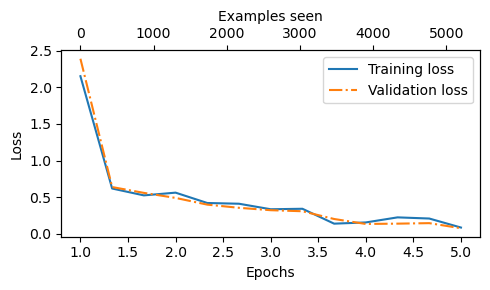

In [193]:
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

In [185]:
epochs_tensor = torch.linspace(1, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(1, examples_seen, len(train_accs))

In [186]:
epochs_tensor

tensor([1., 2., 3., 4., 5.])

In [187]:
examples_seen_tensor

tensor([1.0000e+00, 1.3008e+03, 2.6005e+03, 3.9002e+03, 5.2000e+03])

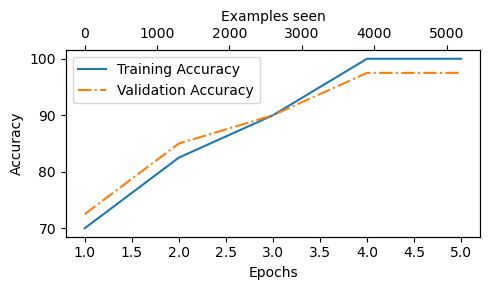

In [188]:
plot_values(epochs_tensor, examples_seen_tensor, [float(p) for p in train_accs], [float(p) for p in val_accs], label='Accuracy')

In [183]:
[float(p) for p in val_accs]

[72.5, 85.0, 90.0, 97.5, 97.5]

In [194]:
# compute accuracy over the whole dataset

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

train_accuracy, val_accuracy, test_accuracy

('97.21', '97.32', '95.67')

### Use LLM as spam classifier

In [195]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (sublayer1): SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (sublayer2): SublayerConnection(
        (norm): LayerNorm()
        (dropout): Dr

In [198]:
model.pos_emb.weight.shape[0]

1024

In [220]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0] # mistake in original implementation

    if max_length is None:
        max_length = supported_context_length
    else:
        max_length = min(max_length, supported_context_length)

    input_ids = input_ids[:max_length]
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    # print(input_ids)
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :] # logits of last output token Shape should be (1, 2)
    
    predicted_label = torch.argmax(logits, dim=-1).item()
    return 'not spam' if predicted_label == 0 else 'spam', logits

In [221]:
text_1 = 'How are you doing'

classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length)

('not spam', tensor([[ 3.7726, -2.6696]]))

In [233]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

('not spam', tensor([[ 2.5016, -1.4145]]))


In [215]:
train_dataset.max_length

120

In [227]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

('spam', tensor([[0.3936, 0.8904]]))


In [228]:
# save the model
torch.save(model.state_dict(), 'spam_review_classifier.pth')

In [229]:
model_state_dict = torch.load('spam_review_classifier.pth')
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [ ]:
# max_length is quite important, having too many padding tokens will lead all inputs to be classified as spam.